This Notebook estimates the probability of observing a fracture that accommodates a displacement that exceeds a given threshold at a given distance away from a fault during an earthquake. In this probabilistic fault displacement hazard analysis (PFDHA) model, the user can specify $D_{o}$ and obtain the hazard curve $P(D>D_{o})$. This model is best applied to estimating secondary displacements for strike-slip earthquakes with expected widespread fracturing across immature fault zones  

This work is developed in: 
Rodriguez Padilla, A. M., & Oskin, M. E. (NNNN). A probabilistic displacement hazard assessment framework for coseismic distributed fracturing from strike-slip earthquakes.

First, we briefly introduce the derivation of $P(D>D_o)$. Additional details are given in Rodriguez Padilla and Oskin (202X).
The coseismic displacements accommodated by a fracture population distributed within the damage zone of a fault may be described by a power-law of the form: 
\begin{equation}
f(D) =\alpha D^{-n}\tag{1}
\end{equation}
where D is the fracture displacement, n is the slope of the line in log-log space and $\alpha$ is the intercept. Assuming that f(D) is a probability density function ($\int_{D_{min}}^{D_{max}} f(D) = 1$), we integrate f(D) from $D_{min}$ to $D_{max}$, where $D_{min}$ is the displacement associated with the minimum fracture length $L_{o}$ mapped for an event and $D_{max}$ is the maximum displacement measured at the surface for each event (i.e. the displacement at the fault). This yields the probability that a mapped fracture accommodates a displacement D:

\begin{equation}
P(D) = \int_{D_{min}}^{D_{max}} \alpha D^{-n} dD = \frac{1}{1-n}\alpha D^{1-n} \quad _{D_{min}|^{D_{max}}}\tag{2}
\end{equation}

Through integration of equation 2 and some algebra (see complete derivation in manuscript), we can solve for $\alpha$:

\begin{equation}
\alpha = \frac{1-n}{D_{max}^{1-n}-D_{min}^{1-n}}\tag{3}
\end{equation}

Different materials and infrastructure will yield in response to different displacement magnitudes. Thus, we are interested in the probability that the displacement on a mapped fracture exceeds that threshold. In our model, this threshold ($D_{o}$) may be adjusted for different engineering applications. $P(D>D_o)$ is given by integrating P(D) from $D_{min}$ to $D_{max}$. Completing the integral yields the probability that D>Do given the observation of a fracture:

\begin{equation}
P(D>D_{o}|fracture) = \frac{1-(\frac{D_{o}}{D_{max}})^{1-n}}{1-(\frac{D_{min}}{D_{max}})^{1-n}}\tag{4}
\end{equation}



In the next code cell, we define some inputs for the model derived from the high-resolution UAV maps for the 2019 Ridgecrest earthquakes. Users may change these to match the inputs empirically determined from Landers, Hector Mine, or El Mayor Cucapah given in Rodriguez Padilla and Oskin (202X) or they may derive their own values based on the rupture map of an earthquake of interest following the approach in https://github.com/absrp/PFDHA_strike_slip_distributed

In [258]:
# First, import required Python packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import corner

In [259]:
# for the detailed derivation of each of these parameters, refer to https://github.com/absrp/PFDHA_strike_slip_distributed
Do  =0.1
# parameters derived from the fracture lenght population from the Ridgecrest high-res aerial imagery (Rodriguez Padilla et al., 2022a)
n = 1.71 # power-law exponent of fracture length distribution
sigma = 0.06 # standard error of the mean (n)

# parameters fixed
Dmin = 10**-3 # equivalent to a 1 meter long fracture
x = np.logspace(np.log10(1),np.log10(20000),50) # 1 m to 20 km distance from the fault

# parameters derived from the fracture density decay with fault-perpendicular distance from the combined Landers, Hector Mine, and Ridgecrest model
best_fit_parameters = pd.read_csv('general_FDHI_best_fit_parameters.txt', header = None)

vo_bestfit = best_fit_parameters[0]
d_bestfit = best_fit_parameters[1]
gamma_bestfit = best_fit_parameters[2]

In [260]:
# set of functions for model 

# estimate the fracture density decay with fault-perpendicular distance
def calc_vx(x,vo,d,gamma):
    m = 2 # Powers and Jordan, 2010
    d = float(d)
    vo = float(vo)
    gamma= float(gamma)
    return (vo * (d**m/(x**m+d**m))**(gamma/m))

# estimate the probability of a fracture hosting a displacement larger than Do given the observation of a fracture
def calc_DDo_f(Dmin,Do,n):
    return ((Do**(1-n))/(Dmin**(1-n)))

# combine the probabilities above to estimate the probability of finding a fracture that accommodates a displacement > Do
# at a given distance away from the fault
def calc_DDo(DDo_f,vx):
    return DDo_f*vx # note vx has been normalized by meters square to be a probability


In [261]:
# for the best fit model:
# calculate vx
vx_bestfit= calc_vx(x,vo_bestfit,d_bestfit,gamma_bestfit)
# calculate D>Do|fr
DDo_f_bestfit = calc_DDo_f(Dmin,Do,n)
# calculate P(D>Do)
P_D_Do_bestfit = calc_DDo(DDo_f_bestfit,vx_bestfit)

In [262]:
# load Markov chain outputs from MCMC fit to density decay to fracture population 
# (each set of three columns represents the values of vo, d, and gamma for one 
# walker in the ensemble, for a total of 200 walkers)

random.seed(0)

Markov_chain = pd.read_csv('onewalker_Markovchain.txt',sep=' ',header=None)

onewalker = Markov_chain.values[:,:3] # subset first walker in ensemble

n_draws = 5000

# randomly draw n_draws samples from Markov chain for parameters vo, d, and gamma
selected_index = random.sample(range(0,len(onewalker)), n_draws)
selection = onewalker[selected_index,:]

vo_ensemble = selection[:,0] 
d_ensemble = selection[:,1]
gamma_ensemble = selection[:,2]

# randomly draw n_draws samples from a normal distribution of mean n and standard deviation sigma
n_distribution = np.random.normal(n, sigma, n_draws)

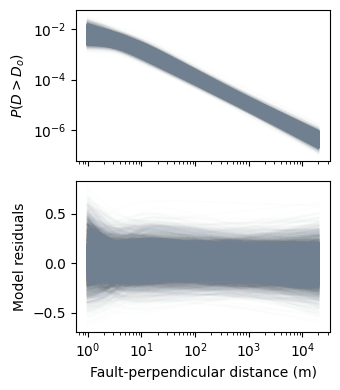

In [263]:
fig, AX = plt.subplots(2,1,dpi=100,figsize=(3.5,4),sharex=True)

line_spec = {
    "alpha":0.01,
    "color":"slategrey",
}

for i_vo,i_d,i_gamma,i_n in zip(vo_ensemble,d_ensemble,gamma_ensemble,n_distribution):
    vx_decay = calc_vx(x,i_vo,i_d,i_gamma)
    PD = calc_DDo_f(Dmin,Do,i_n)
    PD_Do = vx_decay * PD
    residuals = np.log10(PD_Do) - np.log10(P_D_Do_bestfit)
    AX[0].plot(x,PD_Do, **line_spec)
    AX[1].plot(x,residuals, **line_spec)

AX[0].set_yscale('log')
AX[0].set_xscale('log')
AX[0].set_ylabel('$P(D>D_{o})$')

AX[0].plot(x,P_D_Do_bestfit,c='slategrey',label='$D_{o} = %.1f$' %(Do))
AX[1].plot(x,np.log10(P_D_Do_bestfit)-np.log10(P_D_Do_bestfit), color='slategrey')
AX[1].set_xscale('log')
AX[1].set_xlabel('Fault-perpendicular distance (m)')
AX[1].set_ylabel('Model residuals')

plt.tight_layout()

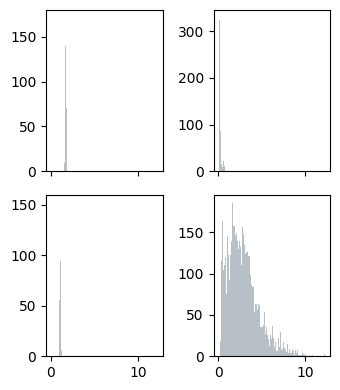

In [264]:
# error distribution and covariance 
fig, AX = plt.subplots(2,2,dpi=100,figsize=(3.5,4),sharex=True)

hist_spec={
    "facecolor":"slategrey",
    "bins":100,
    "alpha":0.5,
}

AX[0,0].hist(n_distribution,**hist_spec)
AX[0,1].hist(vo_ensemble,**hist_spec)
AX[1,1].hist(d_ensemble,**hist_spec)
AX[1,0].hist(gamma_ensemble,**hist_spec)

plt.tight_layout()